In [1]:
import numpy as np
import pandas as pd
from skimage.io import imread
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import gc
import keras
from keras import backend as K
from keras.utils import plot_model
from keras.regularizers import l2
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D
from keras.callbacks import ModelCheckpoint, Callback, LearningRateScheduler, ReduceLROnPlateau

%matplotlib inline

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1057: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1057: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load and Preprocessing the CIFAR10 Dataset

In [2]:
# Create label and digit map
digit2labels = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 
                5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}
label2digits = {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 
                'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}

In [3]:
# Download the CIFAR10 dataset from Kaggle: https://www.kaggle.com/c/cifar-10
# Unzip the download data train.7z and test.7z such that 
# training images is in ./data/train/ and test images are in ./data/test/

preprocessing = False  # whether or not to read the images and save to numpy array
if preprocessing is True:
    train_label = pd.read_csv('./data/trainLabels.csv')['label'].values
    test_label = pd.read_csv('./data/sampleSubmission.csv')
    
    # process the training set, totally 50,000 images
    train_x = []
    train_y = []
    num = 50000
    for i in range(num):
        img = imread('./data/train/{0:d}.png'.format(i + 1))
        label = train_label[i]
        train_x.append(img)
        train_y.append(label)
        
    # process the test set, totally 300,000 images
    test_x = []
    num = 300000
    for i in range(num):
        img = imread('./data/test/{0:d}.png'.format(i + 1))
        test_x.append(img)
        
    # Transform to numpy array
    train_x = np.array(train_x, dtype='uint8')
    train_y = np.array(list(map(lambda x: label2digits[x], train_y))).reshape((-1, 1))
    test_x = np.array(test_x, dtype='uint8')

    # Save to disk
    np.save('./data/train_x.npy', train_x)
    np.save('./data/train_y.npy', train_y)
    np.save('./data/test_x.npy', test_x)

In [4]:
# Load CIFAR10 dataset instead of using the data from Kaggle
(train_x, train_y), (val_x, val_y) = cifar10.load_data()

# Read test images
test_x = np.load('./data/test_x.npy')

# Transform data format
train_x = train_x.astype('float32') / 255
val_x = val_x.astype('float32') / 255
test_x = test_x.astype('float32') / 255

# Subtrack pixel mean
train_x_mean = np.mean(x_train, axis=0)
train_x -= train_x_mean
val_x -= train_x_mean
test_x -= train_x_mean

# Convert class vectors to binary class matrices
train_y = keras.utils.to_categorical(train_y, 10)
val_y = keras.utils.to_categorical(val_y, 10)

# Get the info about the dataset
print('Train:\t\t', train_x.shape, val_y.shape)
print('Valdation:\t', val_x.shape, val_y.shape)
print('Test:\t\t', test_x.shape)

Train:		 (50000, 32, 32, 3) (10000, 10)
Valdation:	 (10000, 32, 32, 3) (10000, 10)
Test:		 (300000, 32, 32, 3)


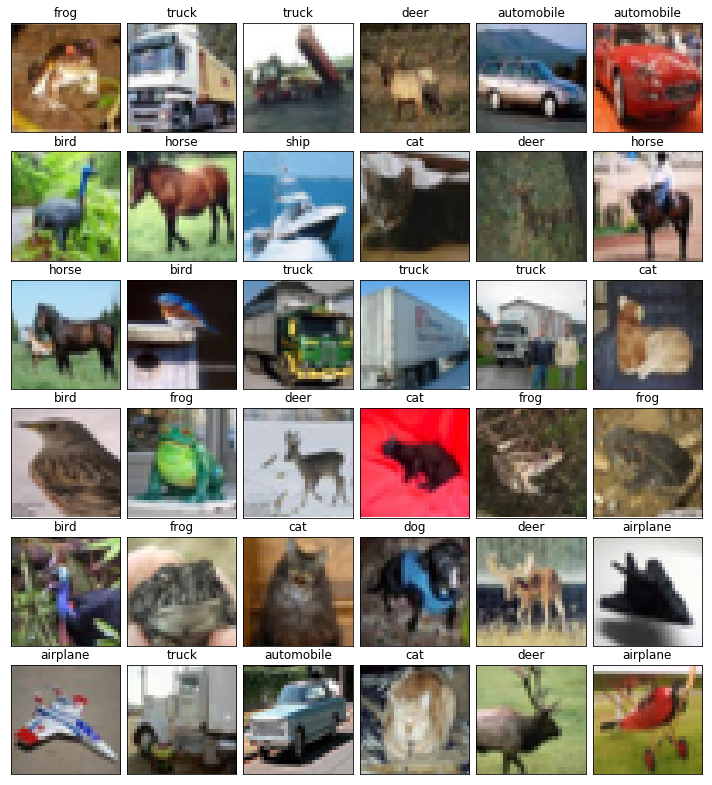

In [5]:
# Visualize the CIFAR10 dataset
nrows, ncols = 6, 6
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 11))
for row in range(nrows):
    for col in range(ncols):
        idx = row * ncols + col
        ax[row][col].imshow(train_x[idx])
        ax[row][col].set_title(digit2labels[np.argmax(train_y[idx])])
        ax[row][col].set_xticks([])
        ax[row][col].set_yticks([])
plt.tight_layout(h_pad=0, w_pad=0)
# fig.savefig('./result/snapshot.png', dpi=200)
plt.show()

# Build VGG Model

VGG is a easy-to-understand CNN model built for ImageNet recognition. Here, the model is built based on the original paper
* [Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/abs/1409.1556)

In [14]:
def lr_schedule(epoch):
    """ Learning rate schedule """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


def vgg(input_shape=(32, 32, 3), classes=10):
    """ Define VGG model using Keras API """
    model = Sequential(name='VGG')
    # Block # 1
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', 
                     input_shape=input_shape, name='block1_conv1'))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', 
                     input_shape=input_shape, name='block1_conv2'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid', name='block1_pool'))
    model.add(Dropout(rate=0.25, name='block1_dropout'))
    
    # Block # 2
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', 
                     input_shape=input_shape, name='block2_conv1'))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', 
                     input_shape=input_shape, name='block2_conv2'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid', name='block2_pool'))
    model.add(Dropout(rate=0.3, name='block2_dropout'))
    
    # Block # 3
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', 
                     input_shape=input_shape, name='block3_conv1'))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', 
                     input_shape=input_shape, name='block3_conv2'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid', name='block3_pool'))
    model.add(Dropout(rate=0.35, name='block3_dropout'))
    
    # Fully connected layers
    model.add(Flatten(name='flatten'))
    model.add(Dense(units=256, activation='relu', name='fc1'))
    model.add(Dropout(rate=0.5, name='fc1_dropout'))
    model.add(Dense(units=128, activation='relu', name='fc2'))
    model.add(Dropout(rate=0.5, name='fc2_dropout'))
    model.add(Dense(units=classes, activation='softmax', name='prediction'))
    
    return model

In [15]:
# To reproduce the result, refer to https://keras.io/getting-started/faq/
np.random.seed(42)
random.seed(42)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
tf.set_random_seed(42)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [16]:
# Create VGG model
input_shape = (32, 32, 3)
vgg_model = vgg(input_shape=input_shape, classes=10)

vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 32, 32, 32)        896       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 32)        9248      
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 32)        0         
_________________________________________________________________
block1_dropout (Dropout)     (None, 16, 16, 32)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 64)        18496     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 64)        36928     
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 64)          0         
__________

In [17]:
# Create optimizer
opt = keras.optimizers.Adam(lr=lr_schedule(0))
vgg_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Create call backs
checkpoint = ModelCheckpoint(filepath='./models/vgg_checkpoint.h5', verbose=0, 
                             monitor='val_acc', save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

# Train the model
vgg_history = vgg_model.fit(x=train_x, y=train_y, batch_size=128, epochs=200, verbose=2, 
                            validation_data=(val_x, val_y), callbacks=callbacks)
_ = gc.collect()

Train on 50000 samples, validate on 10000 samples
Epoch 1/300
 - 6s - loss: 1.8700 - acc: 0.2908 - val_loss: 1.4808 - val_acc: 0.4506
Epoch 2/300
 - 5s - loss: 1.4485 - acc: 0.4694 - val_loss: 1.2126 - val_acc: 0.5634
Epoch 3/300
 - 5s - loss: 1.2458 - acc: 0.5541 - val_loss: 1.0653 - val_acc: 0.6219
Epoch 4/300
 - 5s - loss: 1.1184 - acc: 0.6058 - val_loss: 0.9893 - val_acc: 0.6540
Epoch 5/300
 - 5s - loss: 1.0210 - acc: 0.6444 - val_loss: 0.8690 - val_acc: 0.6901
Epoch 6/300
 - 5s - loss: 0.9516 - acc: 0.6707 - val_loss: 0.8223 - val_acc: 0.7077
Epoch 7/300
 - 5s - loss: 0.8914 - acc: 0.6940 - val_loss: 0.7781 - val_acc: 0.7300
Epoch 8/300
 - 5s - loss: 0.8441 - acc: 0.7102 - val_loss: 0.7762 - val_acc: 0.7285
Epoch 9/300
 - 5s - loss: 0.8154 - acc: 0.7213 - val_loss: 0.7342 - val_acc: 0.7422
Epoch 10/300
 - 5s - loss: 0.7807 - acc: 0.7321 - val_loss: 0.7043 - val_acc: 0.7584
Epoch 11/300
 - 5s - loss: 0.7461 - acc: 0.7475 - val_loss: 0.6731 - val_acc: 0.7633
Epoch 12/300
 - 5s - los

Epoch 97/300
 - 5s - loss: 0.3855 - acc: 0.8734 - val_loss: 0.5613 - val_acc: 0.8320
Epoch 98/300
 - 5s - loss: 0.3980 - acc: 0.8686 - val_loss: 0.5539 - val_acc: 0.8336
Epoch 99/300
 - 5s - loss: 0.4026 - acc: 0.8687 - val_loss: 0.5533 - val_acc: 0.8291
Epoch 100/300
 - 5s - loss: 0.3868 - acc: 0.8728 - val_loss: 0.5585 - val_acc: 0.8344
Epoch 101/300
 - 5s - loss: 0.3857 - acc: 0.8726 - val_loss: 0.5643 - val_acc: 0.8343
Epoch 102/300
 - 5s - loss: 0.3925 - acc: 0.8709 - val_loss: 0.5508 - val_acc: 0.8356
Epoch 103/300
 - 5s - loss: 0.3780 - acc: 0.8751 - val_loss: 0.5622 - val_acc: 0.8301
Epoch 104/300
 - 5s - loss: 0.3879 - acc: 0.8726 - val_loss: 0.5581 - val_acc: 0.8322
Epoch 105/300
 - 5s - loss: 0.3914 - acc: 0.8695 - val_loss: 0.5812 - val_acc: 0.8286
Epoch 106/300
 - 5s - loss: 0.3835 - acc: 0.8719 - val_loss: 0.5627 - val_acc: 0.8307
Epoch 107/300
 - 5s - loss: 0.3849 - acc: 0.8728 - val_loss: 0.5561 - val_acc: 0.8357
Epoch 108/300
 - 5s - loss: 0.3909 - acc: 0.8721 - val_lo

Epoch 193/300
 - 5s - loss: 0.3569 - acc: 0.8854 - val_loss: 0.5425 - val_acc: 0.8397
Epoch 194/300
 - 5s - loss: 0.3561 - acc: 0.8846 - val_loss: 0.5558 - val_acc: 0.8429
Epoch 195/300
 - 5s - loss: 0.3524 - acc: 0.8875 - val_loss: 0.5577 - val_acc: 0.8388
Epoch 196/300
 - 5s - loss: 0.3478 - acc: 0.8890 - val_loss: 0.5688 - val_acc: 0.8345
Epoch 197/300
 - 5s - loss: 0.3639 - acc: 0.8829 - val_loss: 0.5758 - val_acc: 0.8396
Epoch 198/300
 - 5s - loss: 0.3572 - acc: 0.8850 - val_loss: 0.5285 - val_acc: 0.8451
Epoch 199/300
 - 5s - loss: 0.3466 - acc: 0.8893 - val_loss: 0.5499 - val_acc: 0.8395
Epoch 200/300
 - 5s - loss: 0.3600 - acc: 0.8851 - val_loss: 0.5660 - val_acc: 0.8360
Epoch 201/300
 - 5s - loss: 0.3591 - acc: 0.8864 - val_loss: 0.5724 - val_acc: 0.8377
Epoch 202/300
 - 5s - loss: 0.3575 - acc: 0.8863 - val_loss: 0.5684 - val_acc: 0.8378
Epoch 203/300
 - 5s - loss: 0.3574 - acc: 0.8861 - val_loss: 0.5614 - val_acc: 0.8387
Epoch 204/300
 - 5s - loss: 0.3558 - acc: 0.8873 - val

Epoch 289/300
 - 5s - loss: 0.3534 - acc: 0.8908 - val_loss: 0.5782 - val_acc: 0.8427
Epoch 290/300
 - 5s - loss: 0.3442 - acc: 0.8928 - val_loss: 0.5832 - val_acc: 0.8436
Epoch 291/300
 - 5s - loss: 0.3457 - acc: 0.8915 - val_loss: 0.5717 - val_acc: 0.8469
Epoch 292/300
 - 5s - loss: 0.3547 - acc: 0.8907 - val_loss: 0.5585 - val_acc: 0.8394
Epoch 293/300
 - 5s - loss: 0.3416 - acc: 0.8930 - val_loss: 0.5781 - val_acc: 0.8409
Epoch 294/300
 - 5s - loss: 0.3523 - acc: 0.8907 - val_loss: 0.5782 - val_acc: 0.8396
Epoch 295/300
 - 5s - loss: 0.3548 - acc: 0.8906 - val_loss: 0.5663 - val_acc: 0.8399
Epoch 296/300
 - 5s - loss: 0.3460 - acc: 0.8926 - val_loss: 0.5906 - val_acc: 0.8380
Epoch 297/300
 - 5s - loss: 0.3402 - acc: 0.8948 - val_loss: 0.5915 - val_acc: 0.8392
Epoch 298/300
 - 5s - loss: 0.3479 - acc: 0.8923 - val_loss: 0.5568 - val_acc: 0.8421
Epoch 299/300
 - 5s - loss: 0.3354 - acc: 0.8967 - val_loss: 0.5940 - val_acc: 0.8407
Epoch 300/300
 - 5s - loss: 0.3369 - acc: 0.8957 - val

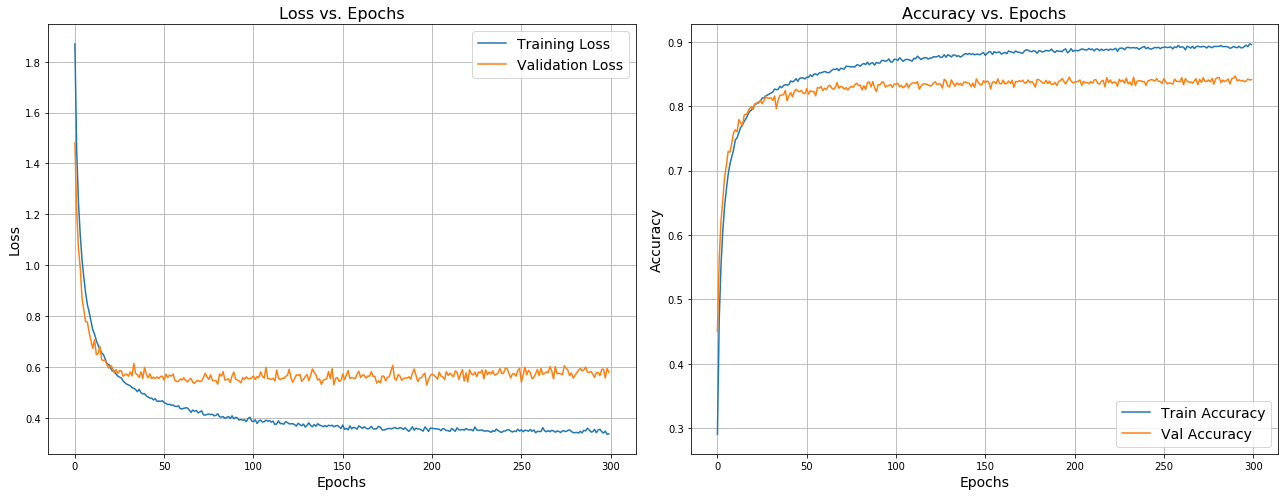

In [19]:
# Visualize the training process
train_loss = vgg_history.history['loss']
train_acc = vgg_history.history['acc']
val_loss = vgg_history.history['val_loss']
val_acc = vgg_history.history['val_acc']

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))
ax[0].plot(train_loss, label='Training Loss')
ax[0].plot(val_loss, label='Validation Loss')
ax[0].set_title('Loss vs. Epochs', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Loss', fontsize=14)
ax[0].legend(fontsize=14)
ax[0].grid(True)

ax[1].plot(train_acc, label='Train Accuracy')
ax[1].plot(val_acc, label='Val Accuracy')
ax[1].set_title('Accuracy vs. Epochs', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)
ax[1].legend(fontsize=14)
ax[1].grid(True)
plt.tight_layout()
fig.savefig('./result/vgg_loss.png', dpi=200)
plt.show()

In [46]:
# Load the saved model
vgg_model = keras.models.load_model('./models/vgg_checkpoint.h5')

# Make predictions
test_pred = vgg_model.predict(test_x)
test_digit = np.argmax(test_pred, axis=1)
test_label = list(map(lambda x: digit2labels[x], test_digit))

idx = list(range(1, 300000 + 1))
df = pd.DataFrame({'id': idx, 'label': test_label})
df.to_csv('./result/vgg_submission.csv', columns=['id', 'label'], index=False)

# ResNet

ResNet is a powerful CNN structure. This is implemented according the original papers:
* [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)
* [Identity Mappings in Deep Residual Networks](https://arxiv.org/abs/1603.05027)

Reference: [Keras example](https://github.com/keras-team/keras/blob/master/examples/cifar10_resnet.py)

In [11]:
def lr_schedule(epoch):
    """ Learning rate schedule """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


def resnet_layer(inputs, filters=16, kernel_size=3, strides=1, 
                 activation='relu', batch_normalization=True):
    """ 
    ResNet layer with Conv2D + Batch_Normalization + Activation structure 
    """
    conv = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same', 
                  activation=None, kernel_initializer='he_normal', kernel_regularizer=None)
    x = conv(inputs)
    if batch_normalization is True:
        x = BatchNormalization()(x)
    if activation is not None:
        x = Activation(activation)(x)
    return x


def resnet(input_shape, num_classes=10):
    """ Build ResNet structure """
    inputs = Input(shape=input_shape, name='inputs')
    
    # block 1: CNN + BN + ReLU
    x = resnet_layer(inputs=inputs, filters=16, kernel_size=3, strides=1)
    
    # block 2: CNN + BN + ReLU + CNN + BN + ReLU, finally merge x and y
    y = resnet_layer(inputs=x, filters=16, kernel_size=3, strides=1)
    y = resnet_layer(inputs=y, filters=16, kernel_size=3, strides=1, activation=None)
    x = keras.layers.add([x, y])
    x = Activation('relu')(x)
    
    # block 3: CNN + BN + ReLU + CNN + BN + ReLU, finally merge x and y
    y = resnet_layer(inputs=x, filters=16, kernel_size=3, strides=1)
    y = resnet_layer(inputs=y, filters=16, kernel_size=3, strides=1, activation=None)
    x = keras.layers.add([x, y])
    x = Activation('relu')(x)
    
    # helper layer: make the channel nums match
    x = Dropout(rate=0.25)(x)
    x = resnet_layer(inputs=x, filters=32, kernel_size=1, strides=2, batch_normalization=False)
    
    # block 4: CNN + BN + ReLU + CNN + BN + ReLU, finally merge x and y
    y = resnet_layer(inputs=x, filters=32, kernel_size=3, strides=1)
    y = resnet_layer(inputs=y, filters=32, kernel_size=3, strides=1, activation=None)
    x = keras.layers.add([x, y])
    x = Activation('relu')(x)
    
    # block 5: CNN + BN + ReLU + CNN + BN + ReLU, finally merge x and y
    y = resnet_layer(inputs=x, filters=32, kernel_size=3, strides=1)
    y = resnet_layer(inputs=y, filters=32, kernel_size=3, strides=1, activation=None)
    x = keras.layers.add([x, y])
    x = Activation('relu')(x)
    
    # helper layer: make the channel nums match
    x = Dropout(rate=0.25)(x)
    x = resnet_layer(inputs=x, filters=64, kernel_size=1, strides=2, batch_normalization=False)
    
    # block 6: CNN + BN + ReLU + CNN + BN + ReLU, finally merge x and y
    y = resnet_layer(inputs=x, filters=64, kernel_size=3, strides=1)
    y = resnet_layer(inputs=y, filters=64, kernel_size=3, strides=1, activation=None)
    x = keras.layers.add([x, y])
    x = Activation('relu')(x)
    
    # block 7: CNN + BN + ReLU + CNN + BN + ReLU, finally merge x and y
    y = resnet_layer(inputs=x, filters=64, kernel_size=3, strides=1)
    y = resnet_layer(inputs=y, filters=64, kernel_size=3, strides=1, activation=None)
    x = keras.layers.add([x, y])
    x = Activation('relu')(x)
    
    # block 8: 
    x = AveragePooling2D(pool_size=8, strides=None, padding='valid')(x)
    x = Flatten()(x)
    outputs = Dense(units=num_classes, activation='softmax', kernel_initializer='he_normal')(x)
    
    # Define the model
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

In [12]:
# To reproduce the result, refer to https://keras.io/getting-started/faq/
K.clear_session()
np.random.seed(42)
random.seed(42)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
tf.set_random_seed(42)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [13]:
# Create ResNet model
input_shape = (32, 32, 3)
resnet_model = resnet(input_shape=input_shape, num_classes=10)

resnet_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         inputs[0][0]                     
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [14]:
# Create optimizer
opt = keras.optimizers.Adam(lr=lr_schedule(0))
resnet_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Create call backs
checkpoint = ModelCheckpoint(filepath='./models/resnet_checkpoint.h5', verbose=0, save_best_only=True)
lr_scheduler = LearningRateScheduler(lr_schedule)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
callbacks = [checkpoint, lr_reducer, lr_scheduler]

# Train the model
resnet_history = resnet_model.fit(x=train_x, y=train_y, batch_size=128, epochs=200, verbose=2, 
                                  validation_data=(val_x, val_y), callbacks=callbacks)
_ = gc.collect()

Learning rate:  0.001
Train on 50000 samples, validate on 10000 samples
Epoch 1/200
Learning rate:  0.001
 - 11s - loss: 1.5522 - acc: 0.4348 - val_loss: 2.3584 - val_acc: 0.3520
Epoch 2/200
Learning rate:  0.001
 - 9s - loss: 1.2047 - acc: 0.5679 - val_loss: 1.2491 - val_acc: 0.5630
Epoch 3/200
Learning rate:  0.001
 - 9s - loss: 1.0291 - acc: 0.6319 - val_loss: 1.0351 - val_acc: 0.6308
Epoch 4/200
Learning rate:  0.001
 - 9s - loss: 0.9222 - acc: 0.6731 - val_loss: 0.9093 - val_acc: 0.6739
Epoch 5/200
Learning rate:  0.001
 - 9s - loss: 0.8512 - acc: 0.7005 - val_loss: 1.0726 - val_acc: 0.6234
Epoch 6/200
Learning rate:  0.001
 - 9s - loss: 0.7933 - acc: 0.7203 - val_loss: 0.9883 - val_acc: 0.6632
Epoch 7/200
Learning rate:  0.001
 - 9s - loss: 0.7401 - acc: 0.7390 - val_loss: 0.9429 - val_acc: 0.6775
Epoch 8/200
Learning rate:  0.001
 - 9s - loss: 0.7053 - acc: 0.7505 - val_loss: 0.8599 - val_acc: 0.7032
Epoch 9/200
Learning rate:  0.001
 - 9s - loss: 0.6654 - acc: 0.7660 - val_loss

Epoch 77/200
Learning rate:  0.0001
 - 9s - loss: 0.1233 - acc: 0.9562 - val_loss: 0.5794 - val_acc: 0.8405
Epoch 78/200
Learning rate:  0.0001
 - 9s - loss: 0.1248 - acc: 0.9564 - val_loss: 0.5863 - val_acc: 0.8397
Epoch 79/200
Learning rate:  0.0001
 - 9s - loss: 0.1236 - acc: 0.9555 - val_loss: 0.5884 - val_acc: 0.8395
Epoch 80/200
Learning rate:  0.0001
 - 9s - loss: 0.1233 - acc: 0.9556 - val_loss: 0.5995 - val_acc: 0.8379
Epoch 81/200
Learning rate:  0.0001
 - 9s - loss: 0.1217 - acc: 0.9562 - val_loss: 0.5947 - val_acc: 0.8381
Epoch 82/200
Learning rate:  0.0001
 - 9s - loss: 0.1207 - acc: 0.9580 - val_loss: 0.5831 - val_acc: 0.8411
Epoch 83/200
Learning rate:  0.0001
 - 9s - loss: 0.1201 - acc: 0.9574 - val_loss: 0.6055 - val_acc: 0.8364
Epoch 84/200
Learning rate:  0.0001
 - 9s - loss: 0.1169 - acc: 0.9585 - val_loss: 0.5874 - val_acc: 0.8438
Epoch 85/200
Learning rate:  0.0001
 - 9s - loss: 0.1185 - acc: 0.9575 - val_loss: 0.6015 - val_acc: 0.8353
Epoch 86/200
Learning rate: 

Epoch 153/200
Learning rate:  5e-07
 - 9s - loss: 0.0975 - acc: 0.9659 - val_loss: 0.6164 - val_acc: 0.8393
Epoch 154/200
Learning rate:  5e-07
 - 9s - loss: 0.0975 - acc: 0.9660 - val_loss: 0.6184 - val_acc: 0.8389
Epoch 155/200
Learning rate:  5e-07
 - 9s - loss: 0.0983 - acc: 0.9662 - val_loss: 0.6162 - val_acc: 0.8391
Epoch 156/200
Learning rate:  5e-07
 - 9s - loss: 0.0979 - acc: 0.9670 - val_loss: 0.6176 - val_acc: 0.8390
Epoch 157/200
Learning rate:  5e-07
 - 9s - loss: 0.0986 - acc: 0.9655 - val_loss: 0.6177 - val_acc: 0.8394
Epoch 158/200
Learning rate:  5e-07
 - 9s - loss: 0.1008 - acc: 0.9647 - val_loss: 0.6169 - val_acc: 0.8387
Epoch 159/200
Learning rate:  5e-07
 - 9s - loss: 0.0989 - acc: 0.9658 - val_loss: 0.6192 - val_acc: 0.8386
Epoch 160/200
Learning rate:  5e-07
 - 9s - loss: 0.0981 - acc: 0.9652 - val_loss: 0.6180 - val_acc: 0.8389
Epoch 161/200
Learning rate:  5e-07
 - 9s - loss: 0.0974 - acc: 0.9668 - val_loss: 0.6185 - val_acc: 0.8385
Epoch 162/200
Learning rate:

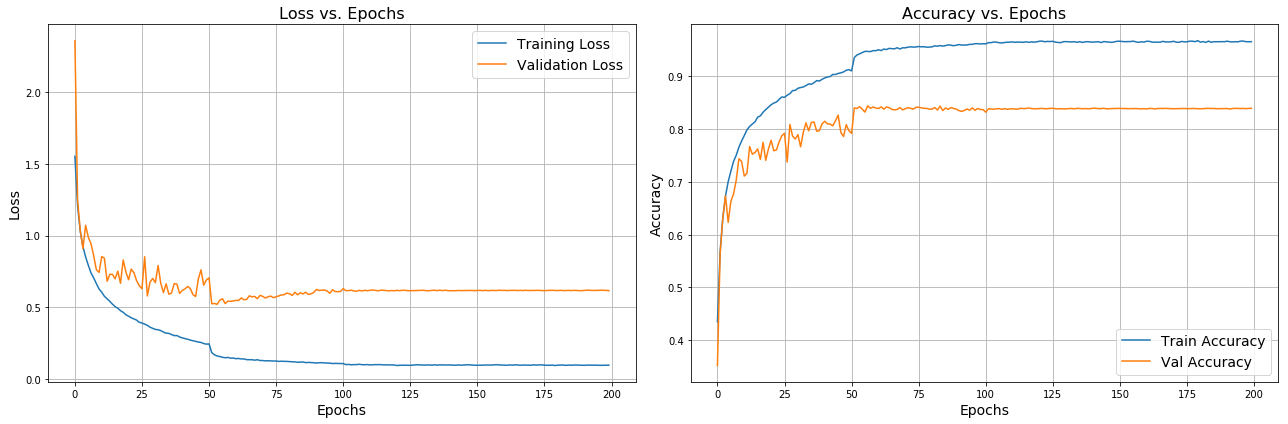

In [15]:
# Visualize the training process
train_loss = resnet_history.history['loss']
train_acc = resnet_history.history['acc']
val_loss = resnet_history.history['val_loss']
val_acc = resnet_history.history['val_acc']

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
ax[0].plot(train_loss, label='Training Loss')
ax[0].plot(val_loss, label='Validation Loss')
ax[0].set_title('Loss vs. Epochs', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Loss', fontsize=14)
ax[0].legend(fontsize=14)
ax[0].grid(True)

ax[1].plot(train_acc, label='Train Accuracy')
ax[1].plot(val_acc, label='Val Accuracy')
ax[1].set_title('Accuracy vs. Epochs', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)
ax[1].legend(fontsize=14)
ax[1].grid(True)
plt.tight_layout()
fig.savefig('./result/resnet_loss.png', dpi=200)
plt.show()

In [16]:
# Load the saved model
resnet_model = keras.models.load_model('./models/resnet_checkpoint.h5')

# Make predictions
test_pred = resnet_model.predict(test_x)
test_digit = np.argmax(test_pred, axis=1)
test_label = list(map(lambda x: digit2labels[x], test_digit))

idx = list(range(1, 300000 + 1))
df = pd.DataFrame({'id': idx, 'label': test_label})
df.to_csv('./result/resnet_submission.csv', columns=['id', 'label'], index=False)

# ResNet

ResNet is a powerful CNN structure. This is implemented according the original papers:
* [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)
* [Identity Mappings in Deep Residual Networks](https://arxiv.org/abs/1603.05027)

Reference: [Keras example](https://github.com/keras-team/keras/blob/master/examples/cifar10_resnet.py)

In [6]:
def lr_schedule(epoch):
    """ Learning rate schedule """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


def resnet_layer(inputs, filters=16, kernel_size=3, strides=1, activation='relu', 
                 batch_normalization=True, l2_ratio=1e-4):
    """ Resnet single layer """
    conv = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same', 
                  activation=None, kernel_initializer='he_normal', kernel_regularizer=l2(l2_ratio))
    y = conv(inputs)
    if batch_normalization is True:
        y = BatchNormalization()(y)
    if activation is not None:
        y = Activation(activation)(y)
        
    return y


def residual(x, filters=16, kernel_size=3, downsample=False, l2_ratio=1e-4):
    """ 
    ResNet layers with multiple Conv2D + Batch_Normalization + Activation structure 
    """
    # Conv block 1
    strides = 1
    if downsample is True:
        strides = 2
        
    y = resnet_layer(x, filters=filters, kernel_size=kernel_size, strides=strides, 
                     activation='relu', batch_normalization=True, l2_ratio=l2_ratio)
    
    y = resnet_layer(y, filters=filters, kernel_size=kernel_size, strides=1, 
                     activation=None, batch_normalization=True, l2_ratio=l2_ratio)
    
    if downsample is True:
        x = resnet_layer(x, filters=filters, kernel_size=1, strides=strides, 
                         activation=None, batch_normalization=False, l2_ratio=l2_ratio)
        
    x = keras.layers.add([x, y])
    x = Activation('relu')(x)
        
    return x


def resnet(input_shape, num_classes=10, l2_ratio=1e-4):
    """ Build ResNet structure """
    # define inputs
    inputs = Input(shape=input_shape, name='inputs')
    
    # block 1: CNN + BN + ReLU
    x = resnet_layer(inputs=inputs, filters=16, kernel_size=3, strides=1, l2_ratio=l2_ratio)
    
    # block 2: stack of residual blocks
    x = residual(x, filters=16, kernel_size=3, downsample=False, l2_ratio=l2_ratio)
    x = residual(x, filters=16, kernel_size=3, downsample=False, l2_ratio=l2_ratio)
    x = residual(x, filters=16, kernel_size=3, downsample=False, l2_ratio=l2_ratio)
    
    # block 3: stack of residual blocks
    x = residual(x, filters=32, kernel_size=3, downsample=True, l2_ratio=l2_ratio)
    x = residual(x, filters=32, kernel_size=3, downsample=False, l2_ratio=l2_ratio)
    x = residual(x, filters=32, kernel_size=3, downsample=False, l2_ratio=l2_ratio)
    
    # block 4: stack of residual blocks
    x = residual(x, filters=64, kernel_size=3, downsample=True, l2_ratio=l2_ratio)
    x = residual(x, filters=64, kernel_size=3, downsample=False, l2_ratio=l2_ratio)
    x = residual(x, filters=64, kernel_size=3, downsample=False, l2_ratio=l2_ratio)
    
    # block 5: final output
    x = AveragePooling2D(pool_size=8, strides=None, padding='valid')(x)
    x = Flatten()(x)
    outputs = Dense(units=num_classes, activation='softmax', kernel_initializer='he_normal')(x)
    
    # Define the model
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

In [7]:
# To reproduce the result, refer to https://keras.io/getting-started/faq/
K.clear_session()
np.random.seed(42)
random.seed(42)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
tf.set_random_seed(42)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [8]:
# Create ResNet model
input_shape = (32, 32, 3)
resnet_model = resnet(input_shape=input_shape, num_classes=10, l2_ratio=1e-4)

resnet_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         inputs[0][0]                     
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [ ]:
# Create optimizer
opt = keras.optimizers.Adam(lr=lr_schedule(0))
resnet_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Create call backs
checkpoint = ModelCheckpoint(filepath='./models/resnet_checkpoint.h5', verbose=0, 
                             monitor='val_acc', save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

# Train the model
resnet_history = resnet_model.fit(x=train_x, y=train_y, batch_size=128, epochs=200, verbose=2, 
                                  validation_data=(val_x, val_y), callbacks=callbacks)
_ = gc.collect()

Learning rate:  0.001
Train on 50000 samples, validate on 10000 samples
Epoch 1/200
Learning rate:  0.001
 - 16s - loss: 1.4697 - acc: 0.5090 - val_loss: 1.9331 - val_acc: 0.4214
Epoch 2/200
Learning rate:  0.001
 - 13s - loss: 1.1125 - acc: 0.6458 - val_loss: 1.5807 - val_acc: 0.5460
Epoch 3/200
Learning rate:  0.001
 - 13s - loss: 0.9286 - acc: 0.7138 - val_loss: 1.2891 - val_acc: 0.5969
Epoch 4/200
Learning rate:  0.001
 - 13s - loss: 0.8109 - acc: 0.7609 - val_loss: 1.2892 - val_acc: 0.6197
Epoch 5/200
Learning rate:  0.001
 - 13s - loss: 0.7329 - acc: 0.7879 - val_loss: 1.3412 - val_acc: 0.6288
Epoch 6/200
Learning rate:  0.001
 - 13s - loss: 0.6644 - acc: 0.8111 - val_loss: 1.0403 - val_acc: 0.7030
Epoch 7/200
Learning rate:  0.001
 - 13s - loss: 0.6043 - acc: 0.8344 - val_loss: 1.0202 - val_acc: 0.6960
Epoch 8/200
Learning rate:  0.001
 - 13s - loss: 0.5560 - acc: 0.8530 - val_loss: 1.0722 - val_acc: 0.7007
Epoch 9/200
Learning rate:  0.001
 - 13s - loss: 0.5211 - acc: 0.8642 - 

In [ ]:
# Visualize the training process
train_loss = resnet_history.history['loss']
train_acc = resnet_history.history['acc']
val_loss = resnet_history.history['val_loss']
val_acc = resnet_history.history['val_acc']

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
ax[0].plot(train_loss, label='Training Loss')
ax[0].plot(val_loss, label='Validation Loss')
ax[0].set_title('Loss vs. Epochs', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Loss', fontsize=14)
ax[0].legend(fontsize=14)
ax[0].grid(True)

ax[1].plot(train_acc, label='Train Accuracy')
ax[1].plot(val_acc, label='Val Accuracy')
ax[1].set_title('Accuracy vs. Epochs', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)
ax[1].legend(fontsize=14)
ax[1].grid(True)
plt.tight_layout()
fig.savefig('./result/resnet_loss.png', dpi=200)
plt.show()

In [ ]:
# Load the saved model
resnet_model = keras.models.load_model('./models/resnet_checkpoint.h5')

# Make predictions
test_pred = resnet_model.predict(test_x)
test_digit = np.argmax(test_pred, axis=1)
test_label = list(map(lambda x: digit2labels[x], test_digit))

idx = list(range(1, 300000 + 1))
df = pd.DataFrame({'id': idx, 'label': test_label})
df.to_csv('./result/resnet_submission.csv', columns=['id', 'label'], index=False)